# SimCLR 

Notebook based (partially) on the source code from: https://github.com/The-AI-Summer/simclr

## Imports

In [1]:
from utils.SimCLR import *

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked un

## Data

In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

print(f"Detected Device: {device}")

Detected Device: cuda


In [3]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

## Plots

In [ ]:
augmenter = Augment(img_size=224)
loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=None, shuffle=True)
plot_sample_batch(loader, num_examples=4, num_views=5)

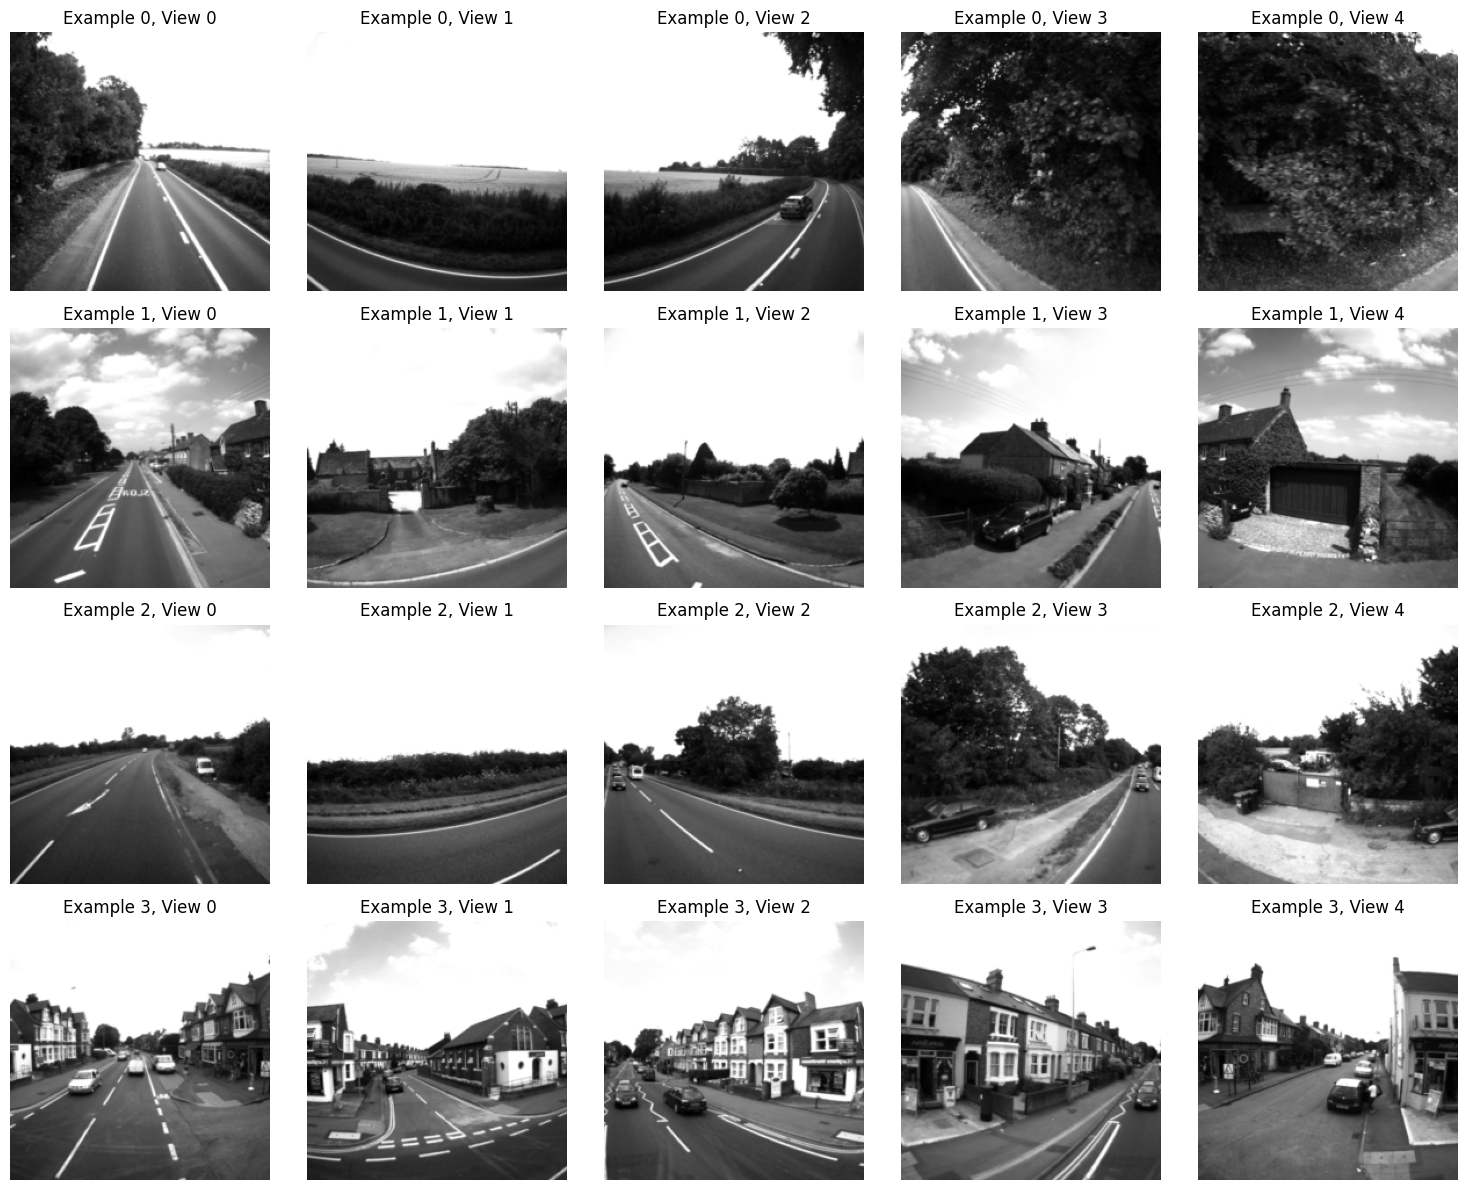

In [ ]:
augmenter = Augment(img_size=224)
loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=augmenter, shuffle=True)
plot_sample_batch(loader, num_examples=4, num_views=5)

## Large Embedding - 64

In [ ]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [ ]:
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM)
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

transform = Augment(img_size=224)
data_loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True)
accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, data_loader)
model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large_views_5.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:449: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type            | Params
------------------------------------------
0 | model | AddProjection   | 11.5 M
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.89

Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 4: 100%|██████████| 71/71 [00:38<00:00,  1.86it/s, loss=3.02, v_num=89, Contrastive loss_step=0.526, Contrastive loss_epoch=3.180]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 71/71 [00:38<00:00,  1.85it/s, loss=3.02, v_num=89, Contrastive loss_step=0.526, Contrastive loss_epoch=3.180]
Model weights saved to models/simclr_weights_large_views_5.pth


### Fine-tuning

In [ ]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = data_df.head(len(data_df) - 300)
test_df = data_df.tail(300)
del data_df

In [ ]:
model_path = "models/simclr_weights_large_views_5.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

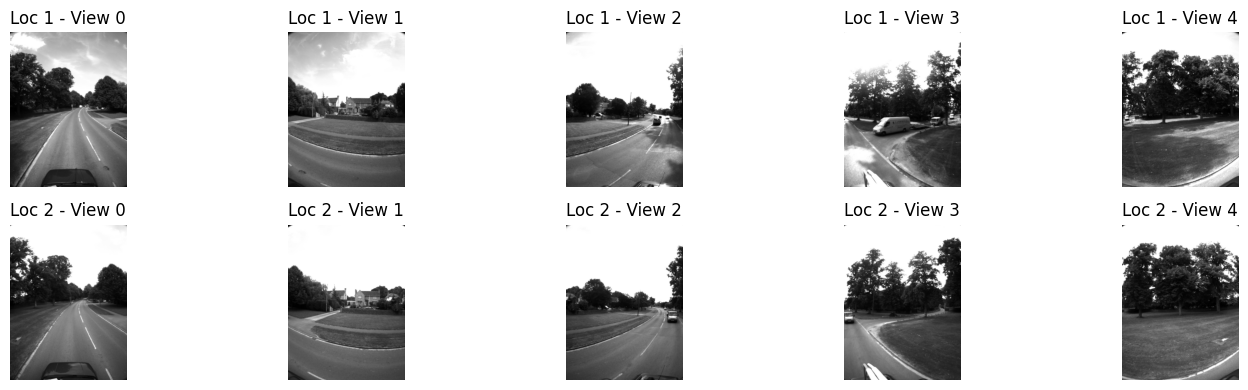

In [ ]:
dataset = FineTuniningMultiViewImageDataset(train_df, base_path='Eynsham/Images', transform=None, num_views=5)
plot_views_from_finetunedataset(dataset, index=0)

In [ ]:
model.set_fine_tuning(True)
model.freeze_backbone()
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
transform = TestAugment(img_size=224) 
train_loader = get_data_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True, fine_tune=True)
test_loader = get_data_loader(test_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True, fine_tune=True)

accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, train_loader)
model.eval()
trainer.test(model, test_loader)

model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_large_views_5_fine_tuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:449: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type            | Params
------------------------------------------
0 | model | AddProjection   | 11.5 M
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
296 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
45.89

Backbone frozen for fine-tuning
Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 4: 100%|██████████| 53/53 [00:39<00:00,  1.33it/s, loss=3.38, v_num=90, Contrastive loss_step=2.180, Contrastive loss_epoch=3.440]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 53/53 [00:39<00:00,  1.33it/s, loss=3.38, v_num=90, Contrastive loss_step=2.180, Contrastive loss_epoch=3.440]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 18/18 [00:42<00:00,  2.35s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test loss           3.4413681030273438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model weights saved to models/simclr_weights_large_views_5_fine_tuned.pth


### Results

In [ ]:
model_path = "models/simclr_weights_large_views_5_fine_tuned.pth"
model = SimCLR_pl(EMBEDDING_SIZE_LARGE, MLP_DIM)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

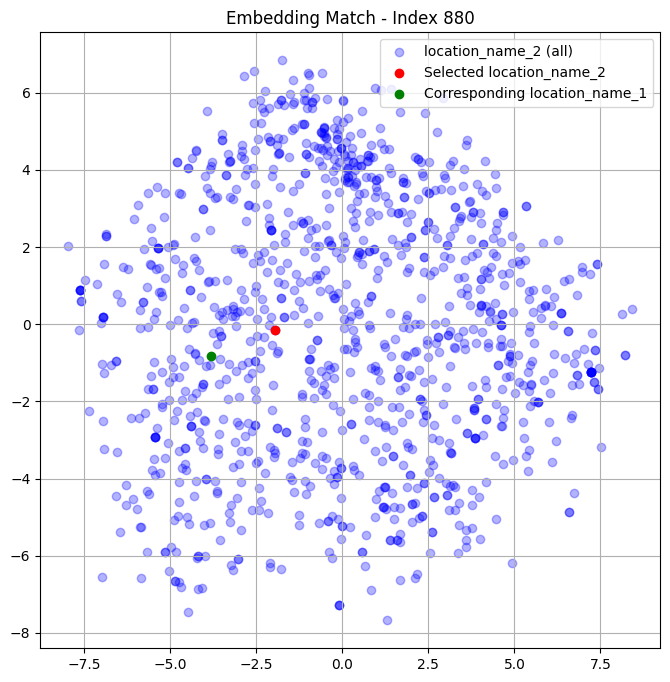

In [ ]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d(model, test_df.copy(), base_path='Eynsham/Images', device=device, batch_size=BATCH_SIZE, transform = transform)

In [ ]:
top1small, top5small, top10small, distance = evaluate_embedding_accuracy(model, test_df, base_path='Eynsham/Images', transform=transform)
print(f"Accuracy for concatenated embeddings SimCLR: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%, Mean Distance to target: {distance:.4f}")

Accuracy for concatenated embeddings SimCLR: Top 1: 34.9644%, Top 5: 66.2811%, Top 10: 76.6014%, Mean Distance to target: 1604.2788


## Small Embedding - 2

In [ ]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [ ]:
model = SimCLR_pl(EMBEDDING_SIZE_SMALL, MLP_DIM)
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

transform = Augment(img_size=224)
data_loader = get_data_loader(data_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True)
accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, data_loader)
model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_small_views_5.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:449: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type            | Params
------------------------------------------
0 | model | AddProjection   | 11.4 M
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.76

Optimizer Adam, Learning Rate 0.0003, Effective batch size 320
Epoch 2:  48%|████▊     | 34/71 [00:20<00:22,  1.65it/s, loss=4.39, v_num=91, Contrastive loss_step=4.320, Contrastive loss_epoch=4.580]

/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Model weights saved to models/simclr_weights_small_views_5.pth


### Fine-tuning

In [ ]:
data_df = pd.read_csv("data/nearest_places_mapping.csv")
data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = data_df.head(len(data_df) - 300)
test_df = data_df.tail(300)
del data_df

In [ ]:
model_path = "models/simclr_weights_small_views_5.pth"
model = SimCLR_pl(EMBEDDING_SIZE_SMALL, MLP_DIM)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

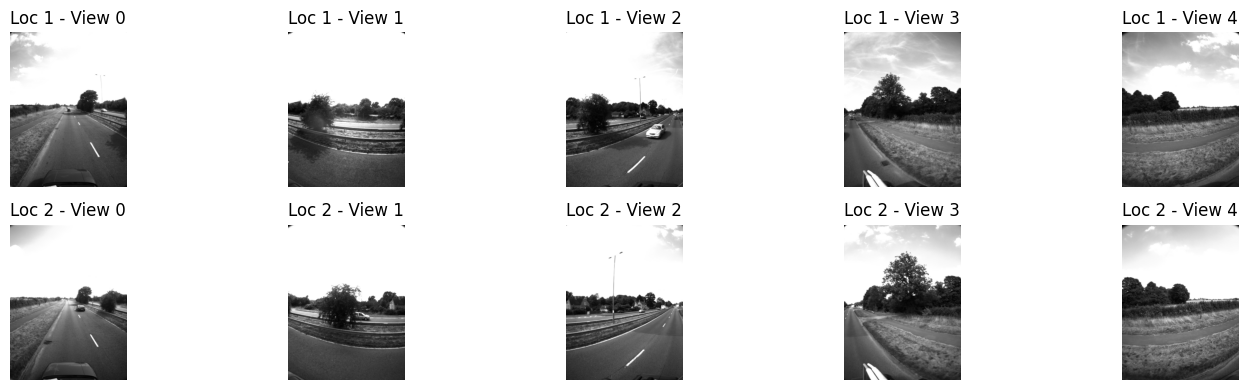

In [ ]:
dataset = FineTuniningMultiViewImageDataset(train_df, base_path='Eynsham/Images', transform=None, num_views=5)
plot_views_from_finetunedataset(dataset, index=0)

In [ ]:
model.set_fine_tuning(True)
model.freeze_backbone()
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
transform = TestAugment(img_size=224) 
train_loader = get_data_loader(train_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True, fine_tune=True)
test_loader = get_data_loader(test_df, BATCH_SIZE, base_path='Eynsham/Images', transform=transform, shuffle=True, fine_tune=True)

accumulator = GradientAccumulationScheduler(scheduling={0: GRADIENT_ACCUMULATION_STEPS})
trainer = Trainer(callbacks=[accumulator],
                  accelerator='gpu',
                  devices=available_gpus,
                  max_epochs=MAX_EPOCHS)

trainer.fit(model, train_loader)
model.eval()
trainer.test(model, dataloaders=test_loader)

model = model.to("cpu")
os.makedirs("models/", exist_ok=True)
model_path = "models/simclr_weights_small_views_5_fine_tuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")
del model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene-matching/utils/SimCLR.py:450: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,

  | Name  | Type            | Params
------------------------------------------
0 | model | AddProjection   | 11.4 M
1 | loss  | ContrastiveLoss | 0     
------------------------------------------
264 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.76

Backbone frozen for fine-tuning
Optimizer Adam, Learning Rate 0.0003, Effective batch size 160
Epoch 0: 100%|██████████| 106/106 [00:39<00:00,  2.67it/s, loss=4.3, v_num=62, Contrastive loss_step=1.130, Contrastive loss_epoch=4.440]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 106/106 [00:39<00:00,  2.66it/s, loss=4.3, v_num=62, Contrastive loss_step=1.130, Contrastive loss_epoch=4.440]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mati/machine_perception/project/scene_matching_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 36/36 [00:12<00:00,  2.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test loss            4.517580986022949
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model weights saved to models/simclr_weights_small_views_5_fine_tuned.pth


### Results

In [ ]:
model_path = "models/simclr_weights_small_views_5_fine_tuned.pth"
model = SimCLR_pl(EMBEDDING_SIZE_SMALL, MLP_DIM)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

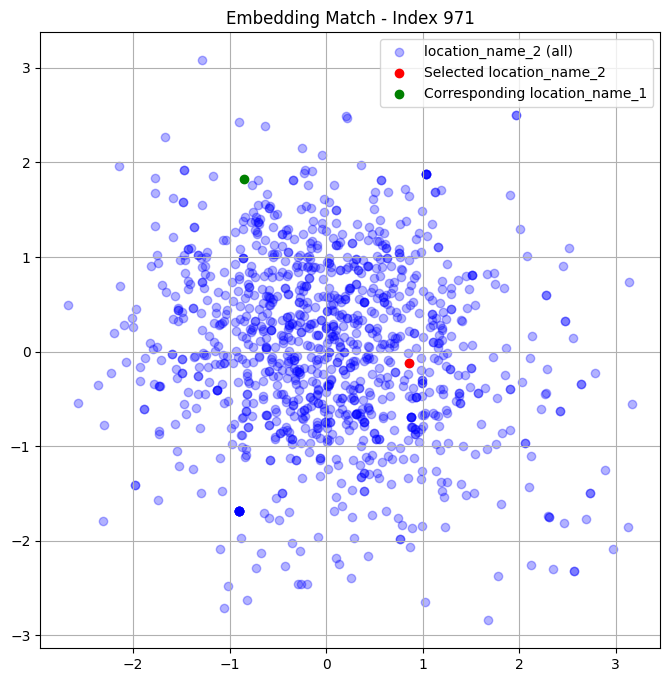

In [ ]:
transform = TestAugment(img_size=224)
plot_embedding_match_2d(model, test_df, base_path='Eynsham/Images', transform=transform, use_pca=False)

In [ ]:
top1small, top5small, top10small, distance = evaluate_embedding_accuracy(model, test_df, base_path='Eynsham/Images', transform=transform)
print(f"Accuracy for concatenated embeddings SimCLR: Top 1: {top1small*100:.4f}%, Top 5: {top5small*100:.4f}%, Top 10: {top10small*100:.4f}%, Mean Distance to target: {distance:.4f}")

Accuracy for concatenated embeddings NetVLAD: Top 1: 0.3559%, Top 5: 0.7117%, Top 10: 1.3345%, Mean Distance to target: 5624.9829
